# Step 1: Import helpful libraries

In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil # round numbers up
%matplotlib inline
# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# For training random forest model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Step 2: Load the data

Next, we'll load the training and test data.  

In [2]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv", index_col=0)
test = pd.read_csv("../input/30-days-of-ml/test.csv", index_col=0)

# Preview the data
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


### EDA

let's see the distribution of the target variable

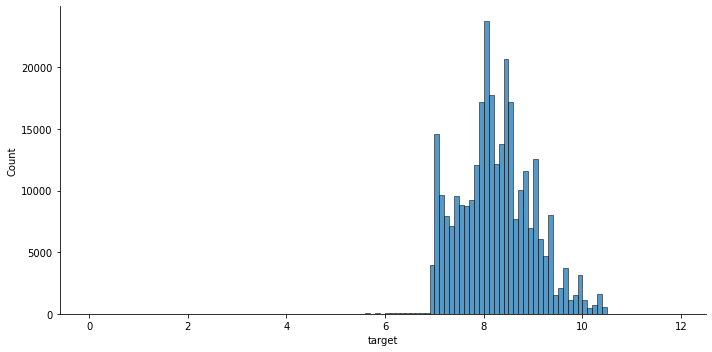

In [3]:
bins = np.arange(0, 12, 0.1)
sns.displot(train.target, height = 5, aspect = 2, bins = bins);

let's see the correlation 

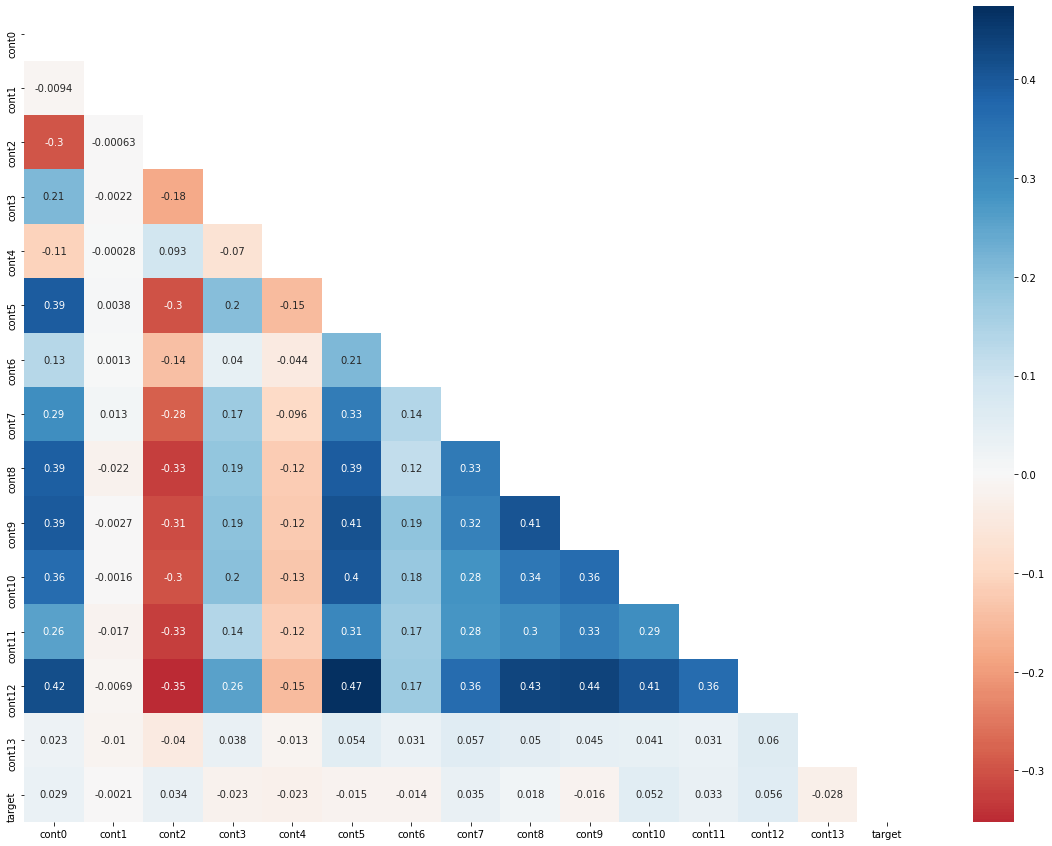

In [4]:
plt.figure(figsize= (20, 15))
# Mask to hide upper-right part of plot as it is a duplicate
mask = np.transpose(np.tril(np.ones(train.corr().shape)))
sns.heatmap(train.corr(), annot = True, center = 0, cmap = 'RdBu', mask = mask);

We can see that target is weakly correlated with all features

In [5]:
num_cols = [col for col in train.columns if 'cont' in col] 
num_cols

['cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13']

In [6]:
def plot(data, cols, features_type, nrows, ncols, bins='auto', target=None, figsize=None,
         hspace=None, wspace=None, color = None):
    '''plot all features vs target or the distribution of features'''
    if figsize != None:
        plt.figure(figsize = figsize)
    for col, plot_num in zip(cols, list(range(1, len(cols)))):
        plt.subplot(nrows, ncols, plot_num)
        if hspace != None or wspace != None:
            plt.subplots_adjust(hspace = hspace, wspace = wspace)
            
        if features_type == 'numerical':
            if target != None:
                plt.scatter(data[col], data[target])
                plt.title(col)
            else:
                sns.histplot(data[col], bins=bins)
                
        if features_type == 'categorical':
            if target != None:
                sns.violinplot(data=data, y=col, x=target, color=color, inner='quartile');
            else:
                countplot_ratio(x = col, data = data, color = color)

Distributions of numerical features

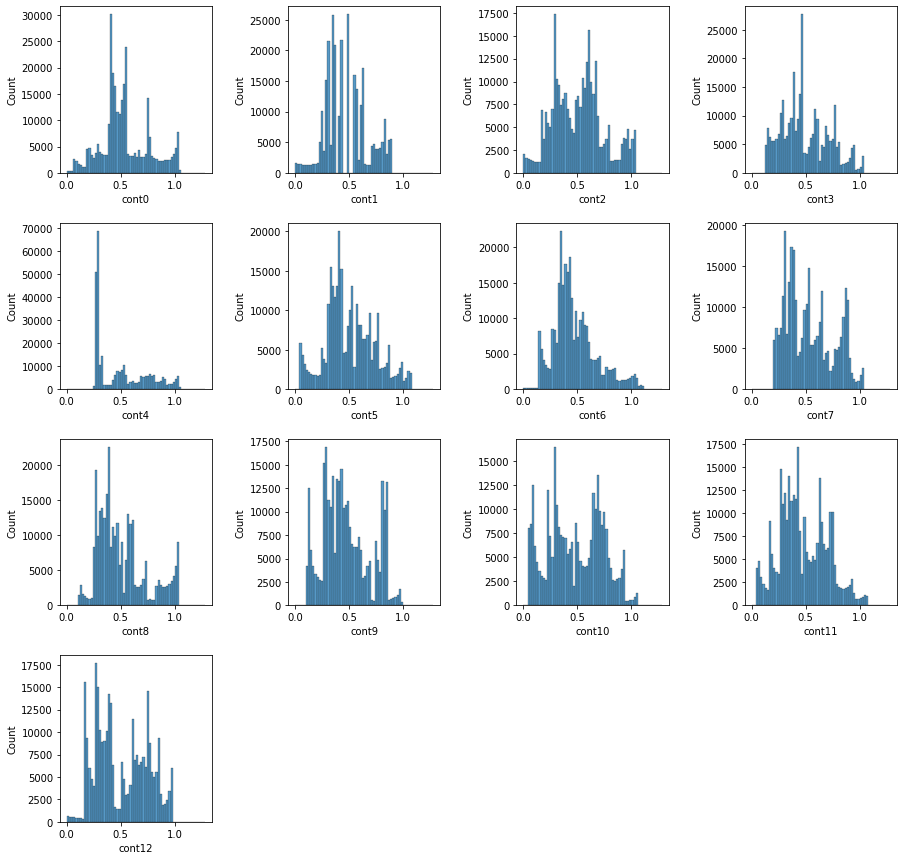

In [7]:
n_cols = 4
n_rows = ceil(len(num_cols)/n_cols)
bins = np.arange(0, 1.3, 0.02)
plot(data=train, cols=num_cols, features_type='numerical', nrows=n_rows, ncols=n_cols, hspace=0.3, wspace=0.5, bins=bins,
    figsize = (15, 15))

let's see the distribution of continuous variable vs target

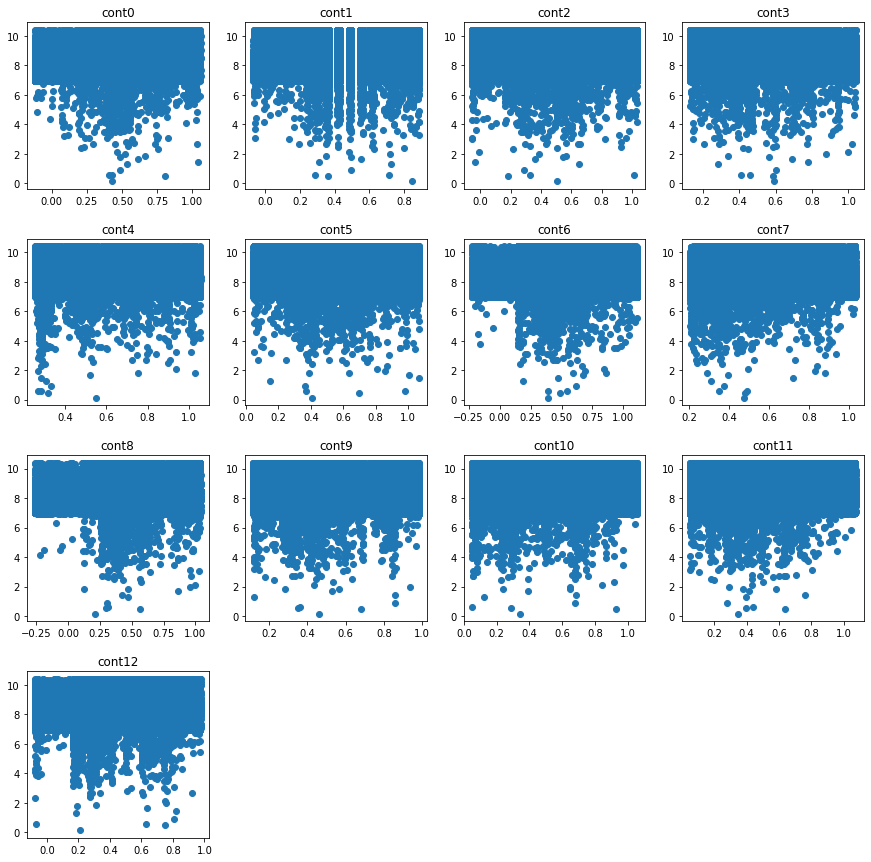

In [8]:
n_cols = 4
n_rows = ceil(len(num_cols)/n_cols)
plot(data=train, target='target', cols=num_cols, features_type='numerical', nrows=n_rows, ncols=n_cols, hspace=0.3,
    figsize = (15, 15))

In [9]:
# List of categorical columns
object_cols = [col for col in train.columns if 'cat' in col]
object_cols

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

Distributions of categorical features

In [10]:
# function to plot the distribution of categorical variable 
# since the countplot function show the counts of observations in each categorical bin using bars.
def countplot_ratio(x = None, data = None, hue = None, ax = None, color = None):
    # plot the variable
    ax = sns.countplot(x, data = data, hue = hue, ax = ax, color = color)
    # names of x labels
    ax.set_xticklabels(ax.get_xticklabels())
    # plot title
    ax.set_title(x + " Distribution")
    # total number of data which used to get the proportion
    total = float(len(data))
    # for loop to iterate on the patches
    for patch in ax.patches:
        # get the height of the patch which represents the number of observations.
        height = patch.get_height()
        # Put text on each patch with the proportion of the observations
        ax.text(patch.get_x()+patch.get_width()/2,height+4,'{:.2f}%'.format((height/total)*100),weight = 'bold',
                fontsize = 12,ha = 'center')

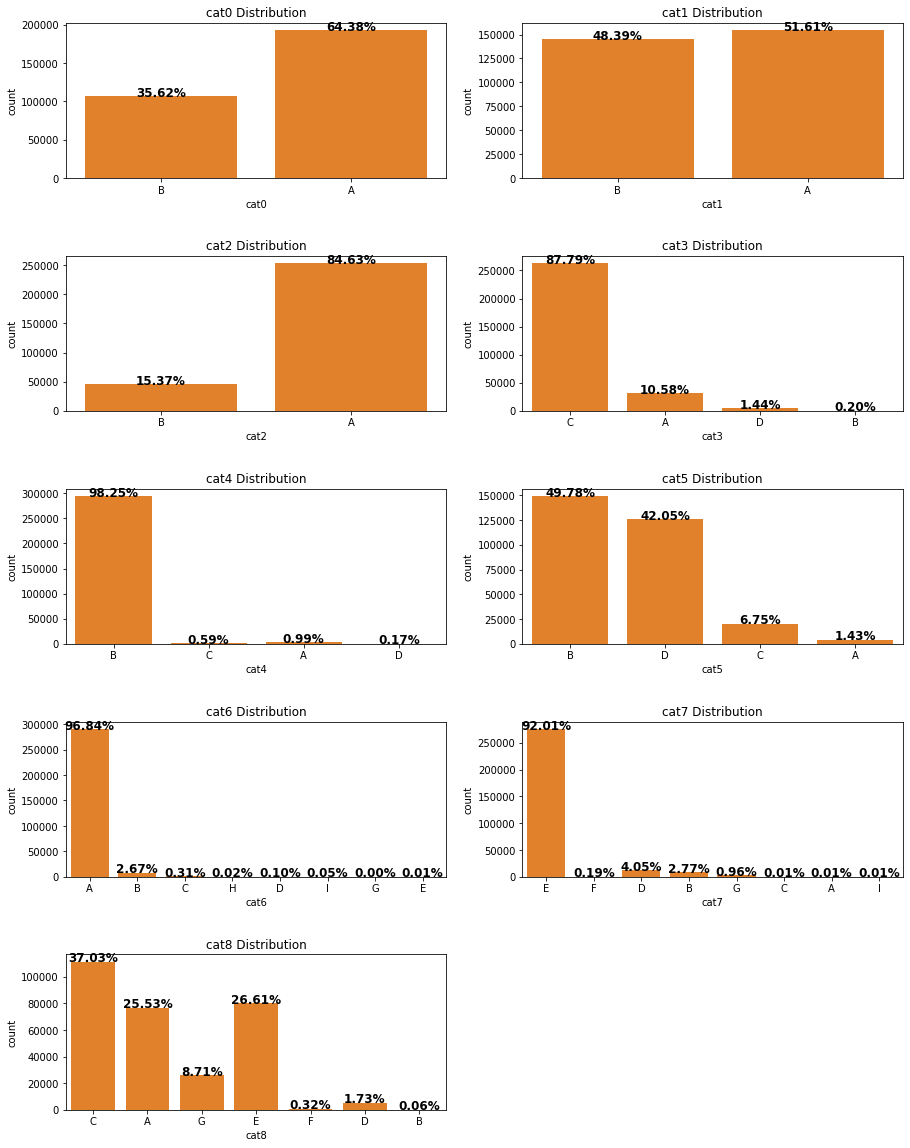

In [11]:
n_cols = 2
n_rows = ceil(len(object_cols)/n_cols)
base_color = sns.color_palette(n_colors=2)[1]
plot(data=train, cols=object_cols, features_type='categorical', nrows=n_rows, ncols=n_cols,
     hspace=0.5, figsize = (15, 20), color=base_color)

let's see the distribution of categorical variable vs target

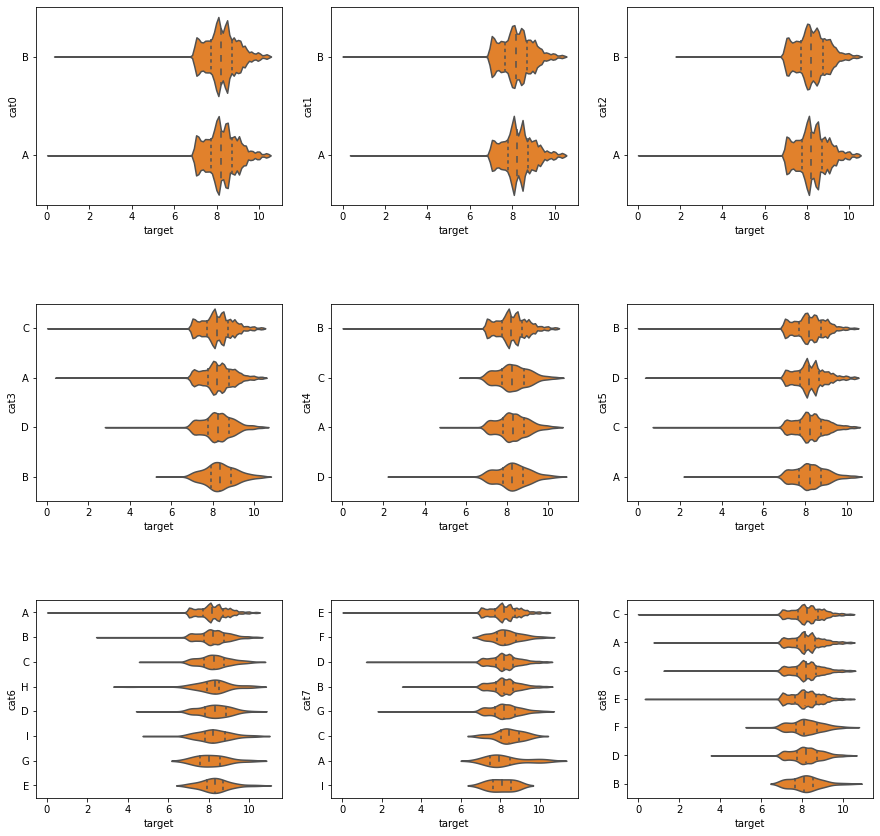

In [12]:
n_cols = 3
n_rows = ceil(len(object_cols)/n_cols)
plot(data=train, target='target', cols=object_cols, features_type='categorical',
     nrows=n_rows, ncols=n_cols, hspace=0.5, figsize = (15, 20), color=base_color)

The next code cell separates the target (which we assign to `y`) from the training features (which we assign to `features`).

In [13]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,B,B,A,A,B,D,A,F,A,O,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,A,A,A,C,B,D,A,D,A,F,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,B,B,A,C,B,D,A,E,C,K,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,A,A,A,C,B,D,A,E,A,N,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


# Step 3: Prepare the data

Next, we'll need to handle the categorical columns (`cat0`, `cat1`, ... `cat9`).  

In [14]:
# ordinal-encode categorical columns
X = features.copy()
X_test = test.copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


Next, we break off a validation set from the training data.

# Step 4: Train a model

Now that the data is prepared, the next step is to train a model.  

In [15]:
fold_3_params = {'n_estimators':2500, 'max_depth' : 3,'learning_rate': 0.1,
              'colsample_bytree':0.13,
              'subsample':1, 'random_state':1, 'reg_alpha':25.9987, 'booster':'gbtree',
              'min_child_weight':1.1}

fold_6_params = {'n_estimators':2500, 'max_depth' : 3,'learning_rate': 0.13,
              'colsample_bytree':0.11,
              'subsample':0.99, 'random_state':1, 'reg_alpha':25.9987, 'booster':'gbtree',
              'min_child_weight':1.1}

fold_7_params = {'n_estimators':2500, 'max_depth' : 3,'learning_rate': 0.1,
              'colsample_bytree':0.13,
              'subsample':0.99, 'random_state':1, 'reg_alpha':25.9987, 'booster':'gbtree',
              'min_child_weight':1.1}

fold_8_params = {'n_estimators':2500, 'max_depth' : 3,'learning_rate': 0.1,
              'colsample_bytree':0.13,
              'subsample':0.99, 'random_state':1, 'reg_alpha':25.9987, 'booster':'gbtree',
              'min_child_weight':1.1}
# fold parameters
n_splits = 10
kfold  = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# To store 'out of fold' predictions, we create an array of zeros
oof_predictions = np.zeros((X.shape[0],))
predictions = 0
total_mean_RMSE = 0

# Generating folds and making training and prediction for each of 10 folds
for fold_num, (train_ix, valid_ix) in enumerate(kfold.split(X)):
    params = {'n_estimators':2500, 'max_depth' : 3,'learning_rate': 0.13,
              'colsample_bytree':0.13,
              'subsample':0.99, 'random_state':1, 'reg_alpha':25.9987, 'booster':'gbtree',
              'min_child_weight':1.1}
    
    X_train, X_valid = X.iloc[train_ix], X.iloc[valid_ix]
    y_train, y_valid = y.iloc[train_ix], y.iloc[valid_ix]
    if fold_num == 3:
        params = fold_3_params
    if fold_num == 6:
        params = fold_6_params
    if fold_num == 7:
        params = fold_7_params
    if fold_num == 8:
        params = fold_8_params
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              verbose=False,
              # These parameters stop training before the model starts overfitting. 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              eval_metric="rmse",
              early_stopping_rounds=100,
              )
    # Getting mean test data predictions 
    predictions += model.predict(X_test) / n_splits
    
    # Now, we get validation data preds. Each fold model get predictions from unseen data.
    # After all folds model get predictions, it will be filled with unseen data preds.
    # We will use it to evaluate hyperparameters performance only.
    oof_predictions[valid_ix] = model.predict(X_valid)
    
    # score for a fold model
    fold_RMSE = np.sqrt(mean_squared_error(y_valid, oof_predictions[valid_ix]))
    print(f"Fold {fold_num} RMSE: {fold_RMSE}")

    # Getting total mean of scores of all fold models 
    total_mean_RMSE += fold_RMSE / n_splits
    
print(f"\nOverall RMSE: {total_mean_RMSE}")

Fold 0 RMSE: 0.715642426076744
Fold 1 RMSE: 0.7153932479339267
Fold 2 RMSE: 0.7146607398074105
Fold 3 RMSE: 0.7166177975782321
Fold 4 RMSE: 0.7211001518658816
Fold 5 RMSE: 0.7138416415359145
Fold 6 RMSE: 0.7165306395971714
Fold 7 RMSE: 0.7176661202424389
Fold 8 RMSE: 0.7190028339769334
Fold 9 RMSE: 0.7119946377733042

Overall RMSE: 0.7162450236387957


In [16]:
from sklearn.model_selection import GridSearchCV
def  Hyperparameter_tuning(params):
        '''We use this function to get the best hyperparameters
        Parameters
        ----------
        param: dict
        A dictionary of hyperparameters names and lists of possible values of it
        example:
        param = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}'''
        params = params
        model = XGBRegressor(tree_method = 'gpu_hist')
        clf = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_mean_squared_error', 
                           verbose=2)
        clf.fit(X, y)
        print("Best parameters:", clf.best_params_)
        print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In the code cell above, we set `squared=False` to get the root mean squared error (RMSE) on the validation data.

# Step 5: Submit to the competition

We'll begin by using the trained model to generate predictions, which we'll save to a CSV file.

In [17]:
output = pd.DataFrame()
output["id"] = test.index
output["target"] = predictions
# Save the predictions to a CSV file
output.to_csv('submission.csv', index=False, header=output.columns)
output.head()

,id,target
0,0,8.049170
1,5,8.386590
2,15,8.405779
3,16,8.525387
4,17,8.124661
